## Notebook to compare the effect of filtering and normalizing. Used to produce illustrations for report.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from os import listdir
import os
import wfdb
from scipy.signal import medfilt
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
import random


from wfdb.processing import resample_singlechan

In [2]:
print(os.getcwd())

/Users/vegy-math808y/Speciale/masters


In [39]:
##adjust read_ecg for other datasets
#from wfdb.processing import resample_singlechan
 
def read_ecg_not_afdb(dataset, path, fs_dt):
    
    # Read ECG signal
    record = wfdb.rdrecord(path)
    
    # Get the ECG signal
    ecg_sig = record.p_signal
    # Since there are two leads of ECGs for each record, we only select the first lead to work with.
    ecg_sig = ecg_sig[:,0]
    
    # Read corresponding annotation file
    #annot = wfdb.rdann(path, 'atr')
    
    if dataset == "mitdb" or dataset == "ltafdb" or dataset == "nsrdb" :
        ann = wfdb.rdann(path, 'atr')
        #resample to 250Hz like AFDB 
        ecg_sig_r, ann_r = wfdb.processing.resample_singlechan(ecg_sig, ann, fs_dt, 250)
        annot_symbol = pd.Series(ann_r.symbol)
        annot_sample = pd.Series(ann_r.sample)
 
    elif dataset == "afdb":
        
        ecg_sig_r = ecg_sig
        
        # Read corresponding annotation file
        ann = wfdb.rdann(path, 'atr')
        QRS = wfdb.rdann(path, 'qrs')

        #get RPeak location (index) 
        annot_sample = pd.Series(QRS.sample)

        #extract and assign labels to individual beats. 
        #Needed since beat types are only defined in intervals in .atr file
        Symb = pd.Series(ann.symbol)
        Samp = pd.Series(ann.sample)
        Rhythm = pd.Series(ann.aux_note)    

        df1 = pd.DataFrame({'Rpeak': QRS.sample})
        df1["label"]=np.nan
        ##print(df1.head(10))
        df2 = pd.DataFrame({'Rpeak': ann.sample,"label": ann.aux_note})
        ##print("dataframe2")
        ##print(df2.head(10))
        newdf = pd.concat([df1,df2], keys = ['1', '2'])
        newdf=newdf.sort_index(ascending=False) 
        #make sure that values from annotation file is on top even if Rpeaks are identical. Important for ffill
        newdf=newdf.sort_values(by=['Rpeak'])
        #perform forward ffill to get annotation to all Rpeaks in QRS.sample
        newdf=newdf.ffill()
        #discard all Rpeaks+Annotations from ann.sample. Avoid adding extra or duplicate beats 
        newdf=newdf.loc[['1']]

        #convert label col to series for further processing 
        annot_symbol = pd.Series(list(newdf["label"]))
        
    else:
        print('not a known dataset')
   
    
    annot_symbol = annot_symbol.replace('(AFIB', 'A')
    annot_symbol = annot_symbol.replace('(N', 'N')
    
    return ecg_sig_r, annot_symbol, annot_sample

In [40]:
#make filter as function to be called pr patient

def bw_filt(ecg_sig, sampfrq):
    #Define first window (200ms) - must be odd. therefore subtract 1
    window200 = int(200*sampfrq/1000)-1 
    #Define second window (600ms)
    window600 = int(600*sampfrq/1000)-1
    med1 = medfilt(ecg_sig, kernel_size=window200)
    med2 = medfilt(med1, kernel_size=window600)
    corr = ecg_sig-med2
    #return corrected signal
    return corr


In [41]:
#make lowpass filter function
#inspired by https://medium.com/analytics-vidhya/how-to-filter-noise-with-a-low-pass-filter-python-885223e5e9b7

from scipy.signal import butter,filtfilt

def butter_lowpass_filter(data, cutoff, sampfrq):
    # Get the filter coefficients 
    #order = 2       # sin wave can be approx represented as quadratic
    #order = 4 according to https://www.sciencedirect.com/science/article/pii/S0026269219306330
    b, a = butter(4, cutoff, btype='low', analog=False, fs=sampfrq)
    y = filtfilt(b, a, data)
    return y

In [44]:
#def build_dataset(patients, interval, fs, afib_beat):
def build_dataset(dataset, fs_dt, afib_beat, interval=4):
    
    list_of_patients = os.listdir('data/'+dataset)
    #list_of_patients= ['data/'+dataset+'/' + i[:-4] for i in list_of_patients if i.endswith('.atr')]
    list_of_patients= [i[:-4] for i in list_of_patients if i.endswith('.atr')]

    print(list_of_patients)
    list_of_patients_test = [list_of_patients[11]]
    
    # Initialize the arrays
    num_cols = 2 * interval * fs  # This specify the length of the heartbeats to be extracted. 
    #OK to use 250Hz because signal will be resampled in 'read_ecg()' to 250Hz
    X = np.ones((1,num_cols))
    Y = np.ones((1,1))
    annot_symb = []
    ids = []
    
    # This list stores the number of extracted heartbeats for each patient.
    num_beats = []
    
    for patient_id in list_of_patients_test:
        file_path = os.getcwd() + '/data/'+dataset+'/' + patient_id
        
        ecg_sig, annot_type, annot_sample = read_ecg_not_afdb(dataset, file_path, fs_dt)
        
        #check what types and how many in each patient
        values, counts = np.unique(annot_type, return_counts=True)
        df = pd.DataFrame({'label':values, 'val':counts})
        #df = pd.DataFrame({'label': ann.symbol})
        #df1 = pd.DataFrame({'Rpeak': QRS.sample})
        print(df.groupby('label').val.sum())
        #f.write(df.groupby('label').val.sum())
        
        
        """Filter baseline wander"""
        #############
        ecg_sig = bw_filt(ecg_sig, fs)
        #print("ecg_sig shape")
        #print(np.shape(ecg_sig))
        
        """Apply lowpass filter  at 100Hz"""
        #############
        ecg_sig = butter_lowpass_filter(ecg_sig, 100, fs)
        
        
        
        # We simply remove the "non-beats" beats from the df_annot dataframe and only keep "normal" and "abnormal" beats.
        df_annot = pd.DataFrame({'annot_type':annot_type,
                              'annot_sample':annot_sample})
        
        f.write(f'N before removal is {len(df_annot)}  for id {patient_id}\n')
        #print(df_annot.describe())
        
        df_annot = df_annot.loc[df_annot.annot_type.isin(afib_beat + ['N'])]
        f.write(f'N after removal is {len(df_annot)}  for id {patient_id}\n')
        
        #print(df_annot.describe())
        
        # The "make_XY" builds the x and y matrics for each extracted heartbeat
        x, y, symbol = make_XY(ecg_sig, df_annot, interval, num_cols, afib_beat)
        annot_symb = annot_symb + symbol
        num_beats.append(x.shape[0])
        X = np.append(X,x,axis = 0)
        Y = np.append(Y,y,axis = 0)
        id_toappend = []
        id_toappend = [patient_id] * len(x)
        ids = ids+id_toappend
        
    # remove top index from both X and Y since these were just used to initialize
    X = np.delete(X,0,axis=0)
    Y = np.delete(Y,0,axis=0)
    
    #oneHotEncode y
    print(Y[1:10])
    encoder = OneHotEncoder(handle_unknown='ignore')
    Y = encoder.fit_transform(Y).toarray()
    print(Y[1:10])

    #transform y to int
    print(Y.dtype)
    Y = np.rint(Y).astype(int)
    print(Y.dtype)
    print(Y[1:10])

    #confirm that arrays are same length and correct shape
    print(np.shape(ids))   
    print(np.shape(X))
    print(np.shape(Y))
    
    return X, Y, annot_symb, ids


def make_XY(ecg_sig, df_annot, interval, num_cols, afib_beat):
    # this function builds the X,Y matrices for each beat
    # it also returns the original symbols for Y
    
    num_row = len(df_annot)
    print("new_row")
    print(num_row)

    x = np.zeros((num_row, num_cols))
    y = np.zeros((num_row,1))
    symbol = []
    
    # count the rows
    row_size = 0
    nextleft= interval*fs
    
    for annot_sample, annot_type in zip(df_annot.annot_sample.values, df_annot.annot_type.values):

        left = max([0,(annot_sample - interval*fs) ])
        right = min([len(ecg_sig),(annot_sample + interval*fs) ])
        #make condition to control overlap between segments
        if left >= nextleft:      
            xx = ecg_sig[left: right]
            
            #check that segments are correct size:
            if len(xx) == num_cols:
                x[row_size,:] = xx
                #y[row_size,:] = int(annot_type in afib_beat)
                
                #generate list with symbols of beats included in window
                symblist = df_annot.loc[(df_annot.annot_sample >= left) & (df_annot.annot_sample<= right)]
                #print(symblist.head(20))
                symblist = list(symblist.annot_type)
                symb_vote = compare(symblist,r)
                y[row_size,:] = int(symb_vote in afib_beat)
                #symbol.append(annot_type)
                symbol.append(symb_vote)
                row_size += 1
                nextleft = left + int(round(2*fs*interval*(1-overlap)))
    
    x = x[:row_size,:]
    y = y[:row_size,:]
    return x, y, symbol


def compare(symbols, r):
        numN = sum(map( lambda x: x == 'N', symbols))
        n = len(symbols)
        if numN > n * r:
            return 'N'
        else:
            return 'A'



In [45]:
"""set initial variables not passed into function"""
#AFDB sampling rate 250hz. Therefor target sampling rate (fs) is set accordingly
fs = 250
# r is the ratio of beats that must be normal in order for window label to be characterized as 'normal' 
r = 0.5
#maximum overlap of windows in ecg_signal
overlap = 0.5

afib_beat = ['A','a']

f = open("test.txt", "w")
    
X, y, annot, ids = build_dataset('afdb', 250, afib_beat)
f.close()



"""


path='./data/mitdb/flt_ol5_win8'

try:
    os.mkdir(path)
    print('made dir dl')
except OSError as error:
    pass                

np.save(path+'/X.npy',np.array(X))
np.save(path+'/y.npy',np.array(y))
np.save(path+'/ids',np.array(ids))
np.save(path+'/annot_data.npy',np.array(annot))
f.write('\n')

f.close()

"""

['04936', '04908', '04048', '05091', '06995', '08405', '05121', '04015', '07859', '07910', '08215', '08378', '08219', '06426', '08434', '04746', '07879', '00735', '05261', '08455', '06453', '04126', '07162', '04043', '03665']
label
(AFL     3544
A       11478
N       30493
Name: val, dtype: int64
new_row
41971
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]
float64
int64
[[1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]]
(7755,)
(7755, 2000)
(7755, 2)


"\n\n\npath='./data/mitdb/flt_ol5_win8'\n\ntry:\n    os.mkdir(path)\n    print('made dir dl')\nexcept OSError as error:\n    pass                \n\nnp.save(path+'/X.npy',np.array(X))\nnp.save(path+'/y.npy',np.array(y))\nnp.save(path+'/ids',np.array(ids))\nnp.save(path+'/annot_data.npy',np.array(annot))\nf.write('\n')\n\nf.close()\n\n"

In [55]:
scaler = MinMaxScaler()
ecg_sig_norm_window = scaler.fit_transform(X)



In [54]:
print(np.shape(ecg_sig_norm))
print(ecg_sig_norm[4000])

(7755, 2000)
[0.59453109 0.62289899 0.60024472 ... 0.52285547 0.53080551 0.54116039]


/Users/vegy-math808y/Speciale/masters/data/afdb/04048


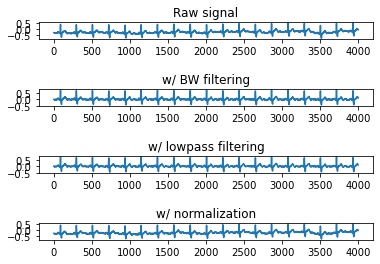

In [24]:

file_path = os.getcwd() + '/data/'+'afdb'+'/' + '04048'

#ecg_sig, annot_type, annot_sample = read_ecg_not_afdb('afdb', file_path, 250)
print(file_path)


record = wfdb.rdrecord(file_path)
    
# Get the ECG signal
ecg_sig = record.p_signal
# Since there are two leads of ECGs for each record, we only select the first lead to work with.
ecg_sig = ecg_sig[:,0]
ecg_sig_bw = bw_filt(ecg_sig, 250)
ecg_sig_lp = butter_lowpass_filter(ecg_sig_bw, 100, 250)


scaler = MinMaxScaler()
ecg_sig_lp = ecg_sig_lp.reshape(-1, 1)
ecg_sig_norm = scaler.fit_transform(ecg_sig_lp)



In [63]:
raw = pd.DataFrame(ecg_sig[40000:40500])
bw = pd.DataFrame(ecg_sig_bw[40000:40500])
lp = pd.DataFrame(ecg_sig_lp[40000:40500])
#norm = pd.DataFrame(ecg_sig_norm[40000:42000])
norm_window = pd.DataFrame(ecg_sig_norm_window[4000])

"\n#plot raw ecg sig\nplt.subplot(4, 1, 1)\nplt.subplots_adjust(hspace=3)\nplt.title('Raw signal')\nplt.plot(ecg_sig[40000:44000])\n\n#Filter baseline wander\n#############\n\nplt.subplot(4, 1, 2)\nplt.title('w/ BW filtering')\nplt.plot(ecg_sig_bw[40000:44000])\n\n\n#Apply lowpass filter  at 100Hz\n#############\n\nplt.subplot(4, 1,3)\nplt.title('w/ lowpass filtering')\nplt.plot(ecg_sig_lp[40000:44000])\n\n#Apply normalization per subject via MinMaxScaler\n#############\nscaler = MinMaxScaler()\n#ecg_sig_lp = ecg_sig_lp.reshape(-1, 1)\n#ecg_sig_norm = scaler.fit_transform(ecg_sig_lp)\nplt.subplot(4, 1, 4)\nplt.title('w/ normalization')\nplt.plot(ecg_sig_norm[40000:44000])\nplt.show()\n\n"

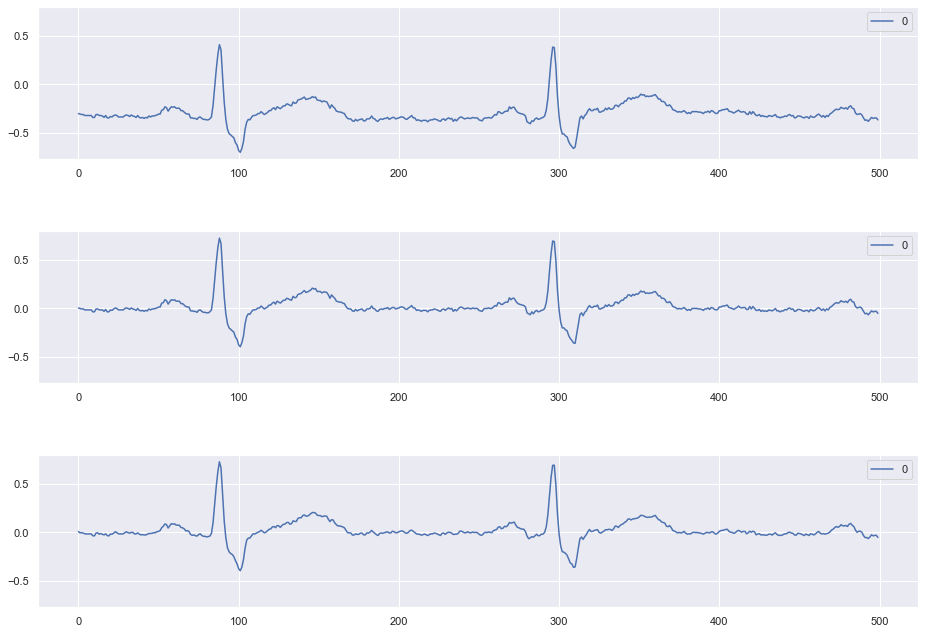

In [64]:
import seaborn as sns
from matplotlib import pyplot as plt
sns.set()


fig, axes = plt.subplots(nrows=3, ncols=1, sharey=True,figsize=(14,10))

fig.tight_layout(pad=4.0)



sns.lineplot(ax=axes[0], data=raw)
sns.lineplot(ax=axes[1], data=bw)
sns.lineplot(ax=axes[2], data= lp)
#sns.lineplot(ax=axes[3], data= norm)


## Make function to plot ecg from all IDs. Use to compare why some has terrible performance

/Users/vegy-math808y/Speciale/masters/data/afdb/04048


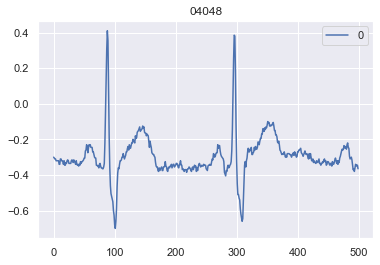

In [136]:

person = '04048'

file_path = os.getcwd() + '/data/'+'afdb'+'/' + person

print(file_path)

record = wfdb.rdrecord(file_path)
    
# Get the ECG signal
ecg_sig = record.p_signal
# Since there are two leads of ECGs for each record, we only select the first lead to work with.
ecg_sig = ecg_sig[:,0]
ecg_sig_bw = bw_filt(ecg_sig, 250)
ecg_sig_lp = butter_lowpass_filter(ecg_sig_bw, 100, 250)

raw = pd.DataFrame(ecg_sig[40000:40500])
bw = pd.DataFrame(ecg_sig_bw[40000:40500])
lp = pd.DataFrame(ecg_sig_lp[40000:40500])

sns.set()
sns.lineplot(data=raw).set(title=person, legend=False)
plt.savefig(person)
plt.show()



/Users/vegy-math808y/Speciale/masters
(128044,)
(128044, 3000)
(128044, 2)


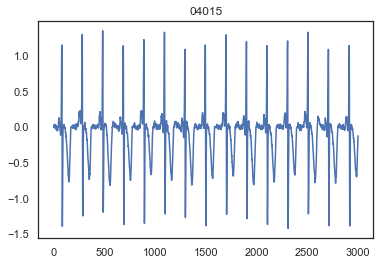

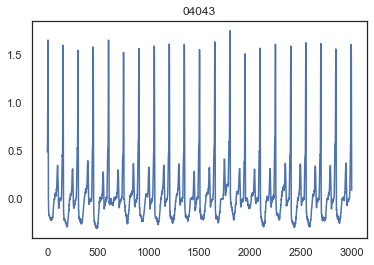

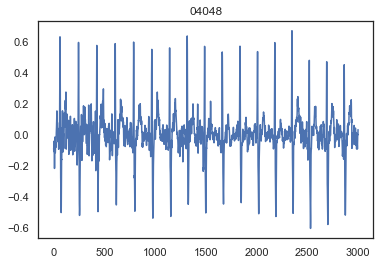

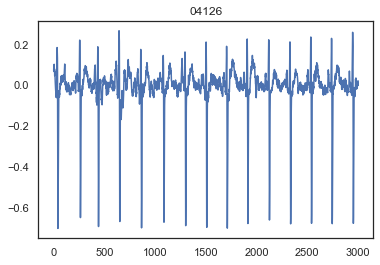

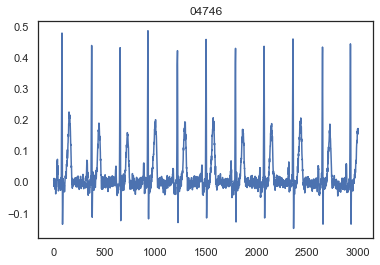

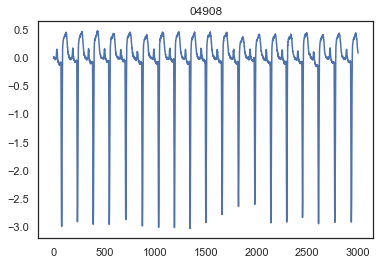

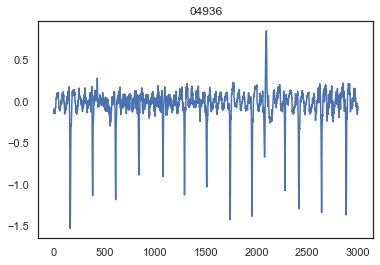

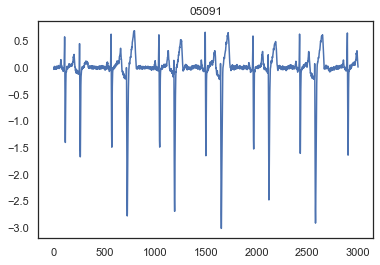

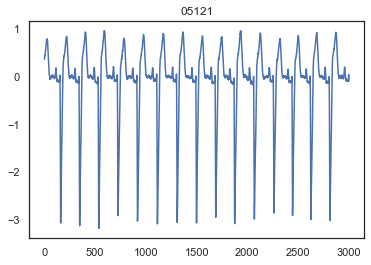

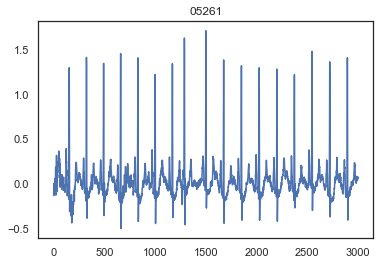

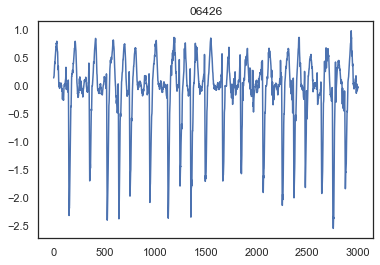

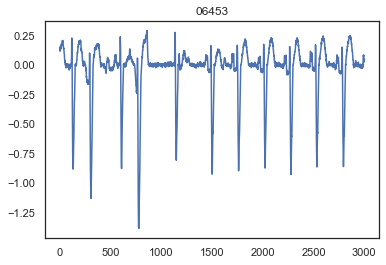

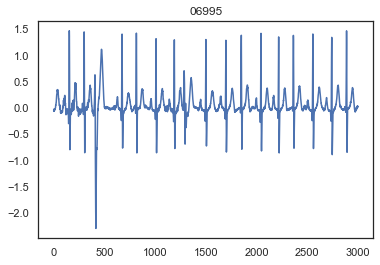

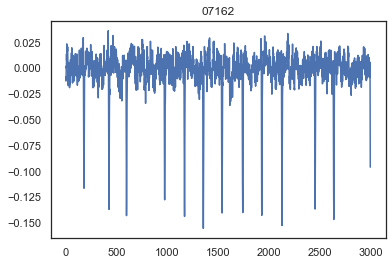

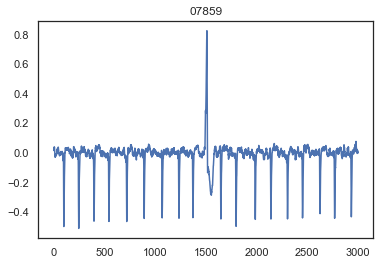

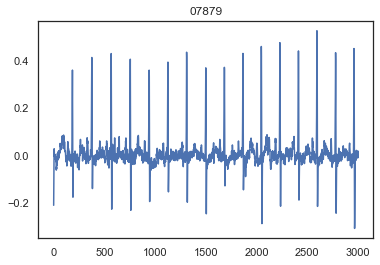

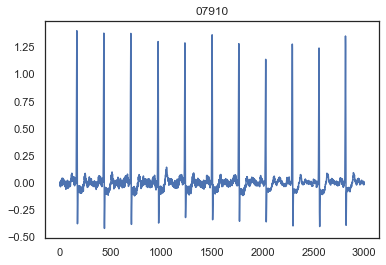

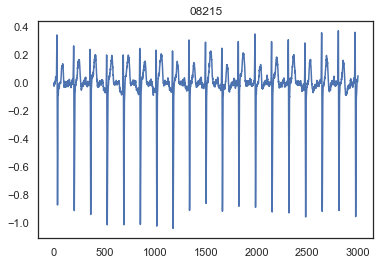

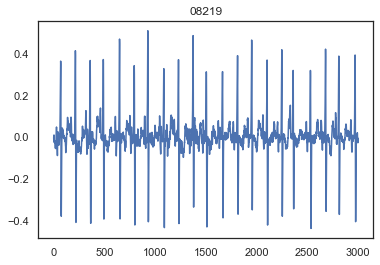

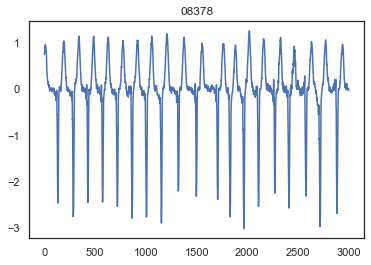

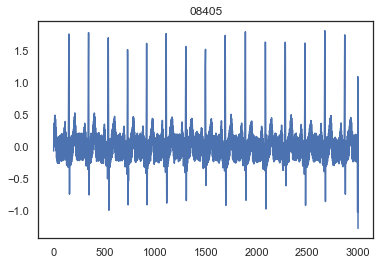

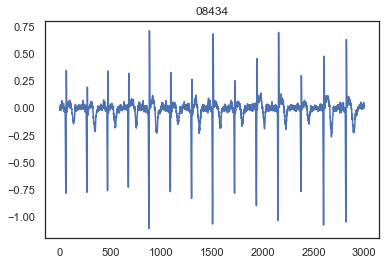

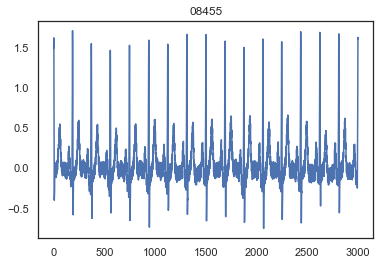

In [170]:
#use already filtered data to speed up...

os.chdir(startdir)
print(os.getcwd())

#Data from AFDB interval 12 filtered
path="./data/" 
X = np.load(path+"X.npy")
y = np.load(path+"y.npy")
ids = np.load(path+"ids.npy")

#confirm that arrays are same length
print(np.shape(ids))   
print(np.shape(X))
print(np.shape(y))

def ecgPlot(person):
    #person = '04048'

    index = np.where( ids == person)

    ids_ill = np.take(ids, index).flatten()
    X_ill = np.take(X, index,0).reshape((len(ids_ill), len(X[0,:])))


    window = pd.DataFrame(X_ill[1000,:])

    sns.set(style='white')
    sns.lineplot(data=window,legend=False).set(title=person)
    plt.savefig('./test/ecg_'+person)
    plt.show()

persons = ['04015','04043','04048','04126','04746','04908',
            '04936','05091','05121','05261','06426','06453','06995','07162',
            '07859','07879','07910','08215','08219','08378','08405','08434',
            '08455']    

for person in persons:
    ecgPlot(person)


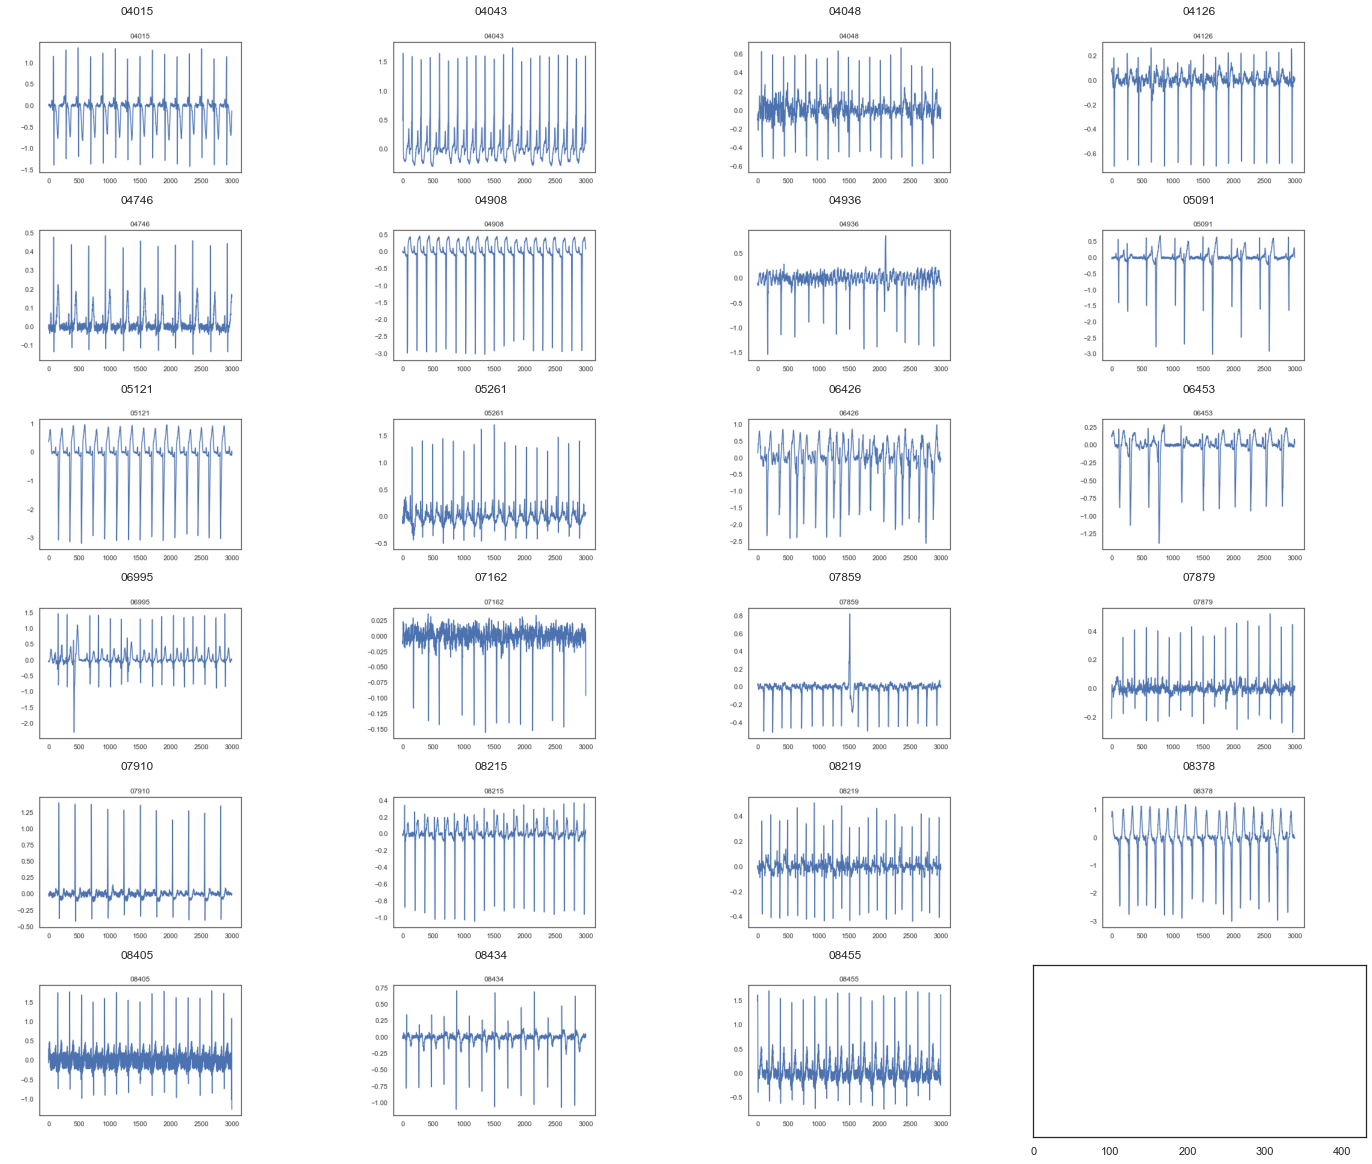

In [173]:
#collect all plots into on big plot
import math
import matplotlib.image as mpimg 

path = './test/ecg_'

fig, axes = plt.subplots(nrows=6, ncols=4, sharey=True, sharex=True,figsize=(20,16))

fig.tight_layout(pad=0.5)

counter=0
c=0
r=0

for person in persons:

    c=math.floor(counter/4)
    r=counter%4
    img = mpimg.imread(path+person+'.png') 
    axes[c,r].imshow(img)
    axes[c,r].set_title(person)
    axes[c,r].axis('off')
    counter+=1

plt.show()

In [179]:
#results = pd.read_pickle("./test/final_metrics.pkl")  
#results
print(pd.__version__)    

1.3.4


[Text(0.5, 1.0, '04048')]

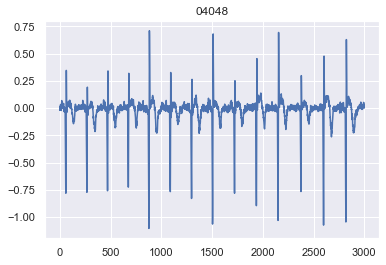

In [148]:
sns.lineplot(data=window,legend=False).set(title=person)

## sort out problems with LOGO. Ensure that split is done accurately. i.e that only one ID is in the testset for instance.

In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from os import listdir
import os
import wfdb
import random
import datetime
import time
import itertools

from tensorflow import keras
from tensorflow.keras import layers

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import Bidirectional
from keras.layers import BatchNormalization

from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix, roc_curve
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score, precision_score, recall_score
from sklearn.model_selection import LeaveOneGroupOut, GroupShuffleSplit
from sklearn.model_selection import GroupKFold
from operator import itemgetter

2023-03-20 10:39:50.674247: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [67]:
#declare model w/ best params from hyperparamsearch (randomsearch)
def buildBest_2():
    combo_input = keras.Input(shape=(X.shape[1], X.shape[2]), name='ecg_segment')

    i = layers.Conv1D(
        filters = 32,
        #tuning kernel size layer 1
        kernel_size=3,
        activation = 'relu',name='conv1')(combo_input)
    i = layers.BatchNormalization(name='batch1')(i)
    i = layers.MaxPooling1D(pool_size=2, strides=2, padding='same',name='max_pool1')(i)
    i = layers.Conv1D(
        filters = 64 , 
        #tuning kernel size layer 2
        kernel_size=3,
        #kernel_size = 5,
        activation = 'relu',name='conv2')(i)
    i = layers.BatchNormalization(name='batch2')(i)
    i = layers.MaxPooling1D(pool_size=2, strides=2, padding='same',name='max_pool2')(i)
    i = layers.Conv1D(
        filters = 32 ,
        #tuning kernel size layer 3
        kernel_size=5,
        activation = 'relu',name='conv3')(i)

    i = layers.BatchNormalization(name='batch3')(i)
    i = layers.MaxPooling1D(pool_size=2, strides=2, padding='same',name='max_pool3')(i)
    i = layers.LSTM(64, return_sequences=False, name='LSTM')(i) 
    i = layers.Dense(128,  name='dense_1')(i)
    combo_output = layers.Dense(2, activation='sigmoid', name='dense_2')(i)

    combo = keras.Model(combo_input, combo_output, name="combo")
    combo.summary()
    #tuning learning_rate
    learning_rate = 0.001442874
    combo.compile(
        loss='binary_crossentropy',
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        metrics = ['accuracy'])
    return combo


In [68]:
def logoloop(model):

    metrics = pd.DataFrame({'model':[],'acc':[], 'tpr':[], 'tnr':[], 'prec':[], 'fpr':[], 'roc_auc':[], 'f1':[],'time':[]},
                        columns=['model','acc', 'tpr', 'tnr', 'prec','fpr','roc_auc','f1','time'])
    history = []
    
    logo = LeaveOneGroupOut()
    logo.get_n_splits(groups=ids)

    for train_index, test_index in logo.split(X, y, ids):
        #print(datetime.datetime.now())
        
        X_train = np.array(list(itemgetter(*train_index)(X)))
        X_test = np.array(list(itemgetter(*test_index)(X)))
        y_train = np.array(list(itemgetter(*train_index)(y)))
        y_test = np.array(list(itemgetter(*test_index)(y)))

        
        
        #y_train_all.append(y_train)
        #y_test_all.append(y_test)
        print(X_train.shape)
        print(y_train.shape)
        print(f"shape of y: {np.shape(y_train)}, type of y: {type(y_train)}")
        print(f"shape of x: {np.shape(X_train)}, type of y: {type(y_train)}")

        
        #Changing name of model to ID of test-individual
        testIDs =  np.array(list(itemgetter(*test_index)(ids)))
        
        #confirm that only one ID is in testset
        values, counts = np.unique(testIDs, return_counts=True)
        df = pd.DataFrame({'ids':values, 'val':counts})
        print(df.groupby('ids').val.sum())
        
        #check what types and how many in testset  each patient
        values, counts = np.unique(y_test[:,0], return_counts=True)
        df = pd.DataFrame({'label':values, 'val':counts})
        print(df.groupby('label').val.sum())
        
        
        
       
        """
        #get time for start of training. Used in evaluate()
        start = time.time()
        
      
        history = model.fit(X_train, y_train,    
                    epochs=20,
                    batch_size = 64,
                    validation_data=(X_test, y_test),
                    verbose=1)
        print("fitted")
        
       

        timeToFit =  time.time()-start
        toappend = evaluate(X_test,y_test, model, testID , timeToFit)


        metrics = pd.concat([metrics, toappend])
        print("appended metrics")
        """

    
    #losscurve(history,'results/logo_loss' )
    #acccurve(history,'results/logo_acc')
    #metrics.to_pickle('results/logo_metrics.pkl')
    
    

In [97]:
startdir = os.getcwd()
print(startdir)

/Users/vegy-math808y/Speciale/masters


/Users/vegy-math808y/Speciale/masters
(128044,)
(128044, 3000)
(128044, 2)


<AxesSubplot:xlabel='id', ylabel='count'>

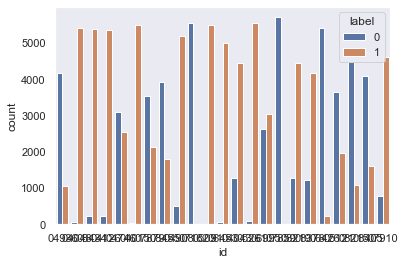

In [132]:

os.chdir(startdir)
print(os.getcwd())

#Data from AFDB interval 12 filtered
path="./data/" 
X = np.load(path+"X.npy")
y = np.load(path+"y.npy")
ids = np.load(path+"ids.npy")

#confirm that arrays are same length
print(np.shape(ids))   
print(np.shape(X))
print(np.shape(y))

# reshape input to be [samples, time steps, features = 1]
#X = np.reshape(X, (X.shape[0], X.shape[1], 1))
#print(np.shape(X))

#os.chdir(startdir+'/test/ol5_win8_rand42')

df = pd.DataFrame({'id':ids, 'label': y[:,0]})





### implementing Normalization pr row i.e pr window

In [96]:
from sklearn.preprocessing import MinMaxScaler
#for this post we will use MinMaxScaler
scaler=MinMaxScaler()

print(X[:5,:10])
#makes makes normalization on transform of X and then back transforms normalized. Do before adding extra  
scaled=scaler.fit_transform(X.T).T
print(scaled[:5,:10])

[[-0.00408873  0.01019138  0.01438872  0.00543207 -0.00484603  0.00410748
   0.02651762  0.02818773  0.02668746  0.04374468]
 [-0.02337951 -0.00905413  0.0167308   0.03581888  0.03103066 -0.00710007
  -0.05754051 -0.06739681 -0.11772696 -0.30231223]
 [ 0.00968412  0.02601644  0.0334342   0.0368001   0.04343563  0.03081767
   0.03532599  0.05835263  0.05791749  0.05603539]
 [ 0.03029726  0.02147748  0.00618806  0.00642165  0.00103594  0.00603089
   0.00778426 -0.00276141 -0.00106465  0.00395325]
 [ 0.0165134   0.00201891  0.00830338  0.00242677 -0.008942   -0.01414995
  -0.02770057 -0.03091255 -0.01976964 -0.03524679]]
[[0.90905461 0.91730379 0.91972847 0.91455449 0.90861714 0.91378931
  0.92673497 0.92769974 0.92683308 0.93668652]
 [0.90295765 0.91118757 0.92600099 0.93696708 0.93421625 0.91231017
  0.88333219 0.87766975 0.84875512 0.74271104]
 [0.91868541 0.92803507 0.93228146 0.93420832 0.93800691 0.9307836
  0.93336444 0.94654634 0.94629724 0.94521981]
 [0.92881158 0.92364098 0.9146

In [133]:
df_plot = df.groupby(['id', 'label']).size().reset_index().pivot(columns='label', index='id', values=0)

df_plot

label,0,1
id,,
04015,39.0,5501.0
04043,1275.0,4446.0
04048,61.0,5413.0
04126,223.0,5370.0
04746,3089.0,2538.0
04908,495.0,5179.0
04936,4178.0,1068.0
05091,15.0,5506.0
05121,3654.0,1964.0


<AxesSubplot:xlabel='id'>

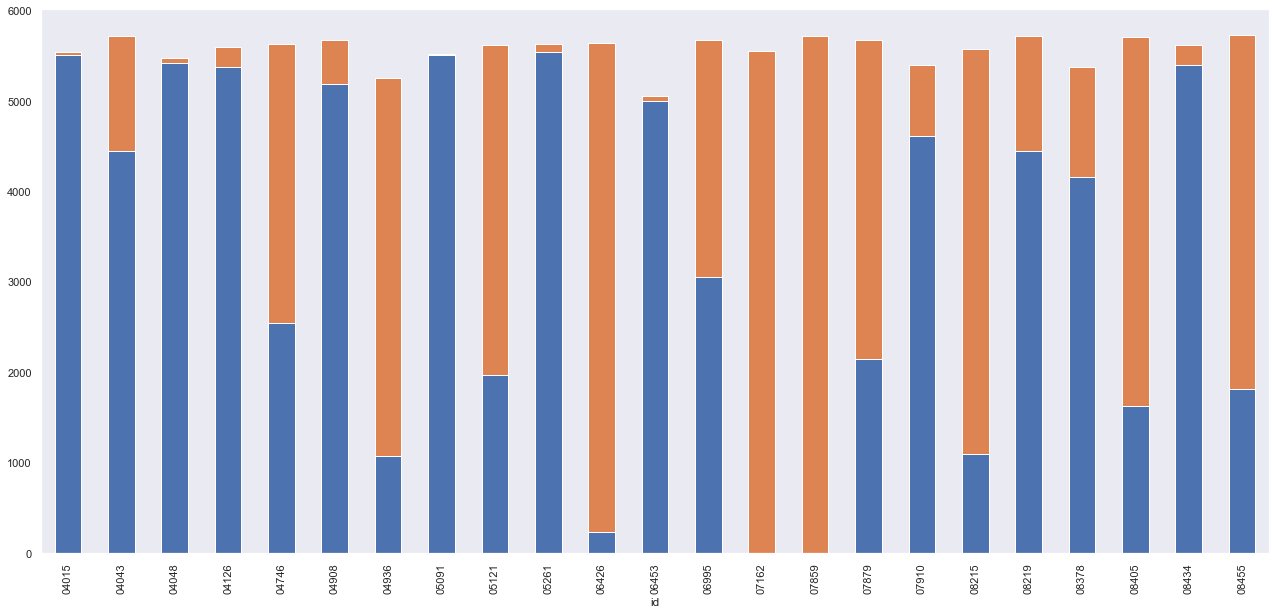

In [135]:
df_plot[[1,0]].plot(kind='bar', stacked=True, figsize=(22,10),legend=False)

In [ ]:
combo = buildBest_2()

logoloop(combo)

label,0,1
id,,
04015,39,5501
04043,1275,4446
04048,61,5413
04126,223,5370
04746,3089,2538
04908,495,5179
04936,4178,1068
05091,15,5506
05121,3654,1964


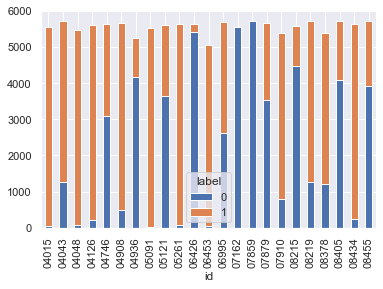

In [89]:
pd.crosstab(df['id'], df['label']).plot(kind='bar', stacked=True)
df_cross = pd.crosstab(df['id'], df['label'])
df_cross

### Generate plot with number of beats and labels pr individual

In [108]:
#modify preprocess steps to get desired dataframe

#def build_dataset(patients, interval, fs, afib_beat):
def build_dataset(dataset, fs_dt, afib_beat, interval=4):
    
    list_of_patients = os.listdir('data/'+dataset)
    #list_of_patients= ['data/'+dataset+'/' + i[:-4] for i in list_of_patients if i.endswith('.atr')]
    list_of_patients= [i[:-4] for i in list_of_patients if i.endswith('.dat')]

    print(list_of_patients)
    list_of_patients_test = [list_of_patients[1]]
    
    # Initialize the arrays
    num_cols = 2 * interval * fs  # This specify the length of the heartbeats to be extracted. 
    #OK to use 250Hz because signal will be resampled in 'read_ecg()' to 250Hz
    X = np.ones((1,num_cols))
    Y = np.ones((1,1))
    annot_symb = []
    ids = []
    
    beats_df = pd.DataFrame({'label': [],'id': []},
                        columns=['label','id'])
    print(beats_df)

    
    # This list stores the number of extracted heartbeats for each patient.
    num_beats = []
    
    for patient_id in list_of_patients:
        file_path = os.getcwd() + '/data/'+dataset+'/' + patient_id
        
        ecg_sig, annot_type, annot_sample = read_ecg_not_afdb(dataset, file_path, fs_dt)
        
        #check what types and how many in each patient
        values, counts = np.unique(annot_type, return_counts=True)
        df = pd.DataFrame({'label':values, 'val':counts})
        #df = pd.DataFrame({'label': ann.symbol})
        #df1 = pd.DataFrame({'Rpeak': QRS.sample})
        print(df.groupby('label').val.sum())
        
        new = pd.DataFrame({'label':annot_type ,'id':patient_id},
                        columns=['label','id'])
        beats_df = pd.concat([beats_df,new])

    return beats_df

##adjust read_ecg for other datasets
#from wfdb.processing import resample_singlechan
 
def read_ecg_not_afdb(dataset, path, fs_dt):
    
    # Read ECG signal
    record = wfdb.rdrecord(path)
    
    # Get the ECG signal
    ecg_sig = record.p_signal
    # Since there are two leads of ECGs for each record, we only select the first lead to work with.
    ecg_sig = ecg_sig[:,0]
    
    # Read corresponding annotation file
    #annot = wfdb.rdann(path, 'atr')
    
    if dataset == "mitdb" or dataset == "ltafdb" or dataset == "nsrdb" :
        ann = wfdb.rdann(path, 'atr')
        #resample to 250Hz like AFDB 
        ecg_sig_r, ann_r = wfdb.processing.resample_singlechan(ecg_sig, ann, fs_dt, 250)
        annot_symbol = pd.Series(ann_r.symbol)
        annot_sample = pd.Series(ann_r.sample)
 
    elif dataset == "afdb":
        ecg_sig_r = ecg_sig
        
        # Read corresponding annotation file
        ann = wfdb.rdann(path, 'atr')
        QRS = wfdb.rdann(path, 'qrs')

        #get RPeak location (index) 
        annot_sample = pd.Series(QRS.sample)

        #extract and assign labels to individual beats. 
        #Needed since beat types are only defined in intervals in .atr file
        Symb = pd.Series(ann.symbol)
        Samp = pd.Series(ann.sample)
        Rhythm = pd.Series(ann.aux_note)    

        df1 = pd.DataFrame({'Rpeak': QRS.sample})
        df1["label"]=np.nan
        ##print(df1.head(10))
        df2 = pd.DataFrame({'Rpeak': ann.sample,"label": ann.aux_note})
        ##print("dataframe2")
        ##print(df2.head(10))
        newdf = pd.concat([df1,df2], keys = ['1', '2'])
        newdf=newdf.sort_index(ascending=False) 
        #make sure that values from annotation file is on top even if Rpeaks are identical. Important for ffill
        newdf=newdf.sort_values(by=['Rpeak'])
        #perform forward ffill to get annotation to all Rpeaks in QRS.sample
        newdf=newdf.ffill()
        #discard all Rpeaks+Annotations from ann.sample. Avoid adding extra or duplicate beats 
        newdf=newdf.loc[['1']]

        #convert label col to series for further processing 
        annot_symbol = pd.Series(list(newdf["label"]))
        
    else:
        print('not a known dataset')
   
    
    annot_symbol = annot_symbol.replace('(AFIB', 'A')
    annot_symbol = annot_symbol.replace('(N', 'N')
    
    return ecg_sig_r, annot_symbol, annot_sample


f = open("testlog.txt", "w")

"""set initial variables not passed into function"""
#AFDB sampling rate 250hz. Therefor target sampling rate (fs) is set accordingly
fs = 250
# r is the ratio of beats that must be normal in order for window label to be characterized as 'normal' 
r = 0.5
#maximum overlap of windows in ecg_signal
overlap = 0.5
afib_beat = ['A','a']


df = build_dataset('afdb', 250, afib_beat, interval=4)

['08434', '08378', '08219', '06426', '05261', '04746', '07879', '06453', '04126', '07162', '08455', '04043', '04908', '04048', '04936', '05091', '06995', '08215', '08405', '05121', '04015', '07859', '07910']
Empty DataFrame
Columns: [label, id]
Index: []
label
A     2310
N    37540
Name: val, dtype: int64
      label     id
0         N  08434
1         N  08434
2         N  08434
3         N  08434
4         N  08434
...     ...    ...
39845     N  08434
39846     N  08434
39847     N  08434
39848     N  08434
39849     N  08434

[39850 rows x 2 columns]
label
(AFL     3544
A       11478
N       30493
Name: val, dtype: int64
      label     id
0         N  08378
1         N  08378
2         N  08378
3         N  08378
4         N  08378
...     ...    ...
45510     N  08378
45511     N  08378
45512     N  08378
45513     N  08378
45514     N  08378

[45515 rows x 2 columns]
label
A    14194
N    45099
Name: val, dtype: int64
      label     id
0         N  08219
1         N  08219
2   

<AxesSubplot:xlabel='id'>

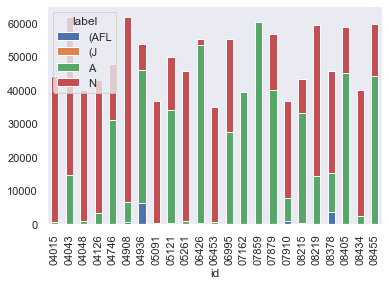

In [125]:
import seaborn as sns
 
import seaborn as sns

#set seaborn plotting aesthetics
sns.set(style='dark')

#create stacked bar chart
df_plot.plot(kind='bar', stacked=True )

<AxesSubplot:xlabel='id'>

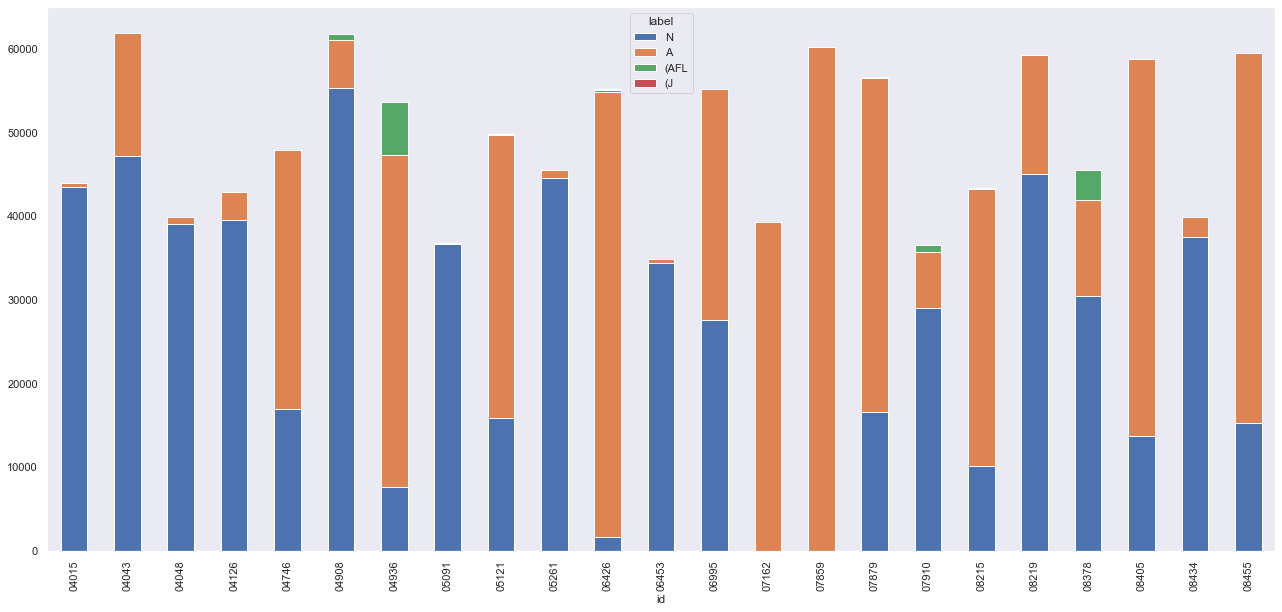

In [128]:

df_plot = df.groupby(['id', 'label']).size().reset_index().pivot(columns='label', index='id', values=0)
df_plot

df_plot[['N','A','(AFL','(J' ]].plot(kind='bar', stacked=True, figsize=(22,10))
